<a target="_blank" href="https://colab.research.google.com/github/yandex-research/rtdl-revisiting-models/blob/main/package/example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

---

**See also** [RTDL](https://github.com/yandex-research/rtdl)
-- **other projects on tabular deep learning**.

---

- This notebook provides a usage example of the
  [rtdl_revisiting_models](https://github.com/yandex-research/rtdl-revisiting-models)
  package.
- Hyperparameters are not tuned and may be suboptimal.

In [1]:
%pip install delu==0.0.23
%pip install rtdl_revisiting_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [2]:
# Réinstalle des versions compatibles de numpy et scipy
!pip install numpy==1.24.4 scipy==1.10.1 --force-reinstall --quiet



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 83.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 56.8 MB/s eta 0:00:00:00:010:01m
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.4 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.4 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.4 which is incompatible.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.10.1 which is incompatible.
woodwork 0.31.0 requires numpy>=1.25.0, but you ha

In [3]:
# ruff: noqa: E402
import math
import warnings
from typing import Dict, Literal

warnings.simplefilter("ignore")
import delu  # Deep Learning Utilities: https://github.com/Yura52/delu
import numpy as np
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn.functional as F
import torch.optim
from torch import Tensor
from tqdm.std import tqdm

warnings.resetwarnings()

from rtdl_revisiting_models import MLP, ResNet, FTTransformer

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set random seeds in all libraries.
delu.random.seed(0)

0

## Dataset

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Chargement du dataset
dataset = pd.read_csv('/kaggle/input/data-set-vv2/processed_dataset_preprocess_v2.csv')

In [7]:
dataset['impaye'].value_counts()

impaye
0    41316
1     8225
Name: count, dtype: int64

In [8]:
import numpy as np
import sklearn.model_selection

# >>> Dataset.
TaskType = Literal["regression", "binclass", "multiclass"]
task_type: TaskType = "binclass"
n_classes = 2


# >>> Colonnes catégorielles (déjà encodées en entiers dans le dataset)
categorical_columns = [
    "invoice_state",
    "folder_state",
    "is_automatic_invoicing_enabled",
    "contract_type",
    "civility",
    "first_name",
    "last_name",
    "folder_reference"
]

# >>> Cible
Y: np.ndarray = dataset["impaye"].to_numpy(dtype=np.int64)

from sklearn.preprocessing import LabelEncoder

for col in categorical_columns:
    dataset[col] = LabelEncoder().fit_transform(dataset[col].astype(str))

# # Ensuite tu peux convertir proprement en int64
# X_cat = dataset[categorical_columns].astype("int64").to_numpy()
# cat_cardinalities = [dataset[col].nunique() for col in categorical_columns]

# >>> Features continues
X_cont_df = dataset.drop(columns=["impaye"])
X_cont: np.ndarray = X_cont_df.to_numpy(dtype=np.float32)
n_cont_features = X_cont.shape[1]

# >>> Categorical features.
# NOTE: the above datasets do not have categorical features, but,
# for the demonstration purposes, it is possible to generate them.
cat_cardinalities = [
    # NOTE: uncomment the two lines below to add two categorical features.
    # 4,  # Allowed values: [0, 1, 2, 3].
    # 7,  # Allowed values: [0, 1, 2, 3, 4, 5, 6].
]
X_cat = (
    np.column_stack(
        [np.random.randint(0, c, (len(X_cont),)) for c in cat_cardinalities]
    )
    if cat_cardinalities
    else None
)

# >>> Labels.
# Regression labels must be represented by float32.
if task_type == "regression":
    Y = Y.astype(np.float32)
else:
    assert n_classes is not None
    Y = Y.astype(np.int64)
    assert set(Y.tolist()) == set(
        range(n_classes)
    ), "Classification labels must form the range [0, 1, ..., n_classes - 1]"

# >>> Split the dataset.
all_idx = np.arange(len(Y))
trainval_idx, test_idx = sklearn.model_selection.train_test_split(
    all_idx, train_size=0.8
)
train_idx, val_idx = sklearn.model_selection.train_test_split(
    trainval_idx, train_size=0.8
)
data_numpy = {
    "train": {"x_cont": X_cont[train_idx], "y": Y[train_idx]},
    "val": {"x_cont": X_cont[val_idx], "y": Y[val_idx]},
    "test": {"x_cont": X_cont[test_idx], "y": Y[test_idx]},
}
if X_cat is not None:
    data_numpy["train"]["x_cat"] = X_cat[train_idx]
    data_numpy["val"]["x_cat"] = X_cat[val_idx]
    data_numpy["test"]["x_cat"] = X_cat[test_idx]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

## Preprocessing

In [9]:
# >>> Feature preprocessing.
# NOTE
# The choice between preprocessing strategies depends on a task and a model.

# (A) Simple preprocessing strategy.
# preprocessing = sklearn.preprocessing.StandardScaler().fit(
#     data_numpy['train']['x_cont']
# )

# (B) Fancy preprocessing strategy.
# The noise is added to improve the output of QuantileTransformer in some cases.
X_cont_train_numpy = data_numpy["train"]["x_cont"]
noise = (
    np.random.default_rng(0)
    .normal(0.0, 1e-5, X_cont_train_numpy.shape)
    .astype(X_cont_train_numpy.dtype)
)
preprocessing = sklearn.preprocessing.QuantileTransformer(
    n_quantiles=max(min(len(train_idx) // 30, 1000), 10),
    output_distribution="normal",
    subsample=10**9,
).fit(X_cont_train_numpy + noise)
del X_cont_train_numpy

for part in data_numpy:
    data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])

# >>> Label preprocessing.
if task_type == "regression":
    Y_mean = data_numpy["train"]["y"].mean().item()
    Y_std = data_numpy["train"]["y"].std().item()
    for part in data_numpy:
        data_numpy[part]["y"] = (data_numpy[part]["y"] - Y_mean) / Y_std

# >>> Convert data to tensors.
data = {
    part: {k: torch.as_tensor(v, device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}

if task_type != "multiclass":
    # Required by F.binary_cross_entropy_with_logits
    for part in data:
        data[part]["y"] = data[part]["y"].float()

## Model

In [34]:
# The output size.
d_out = n_classes if task_type == "multiclass" else 1

# # NOTE: uncomment to train MLP
model = MLP(
    d_in=n_cont_features + sum(cat_cardinalities),
    d_out=d_out,
    n_blocks=2,
    d_block=384,
    dropout=0.1,
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

# # NOTE: uncomment to train ResNet
# model = ResNet(
#     d_in=n_cont_features + sum(cat_cardinalities),
#     d_out=d_out,
#     n_blocks=2,
#     d_block=192,
#     d_hidden=None,
#     d_hidden_multiplier=2.0,
#     dropout1=0.3,
#     dropout2=0.0,
# ).to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)


# model = FTTransformer(
#     n_cont_features=n_cont_features,
#     cat_cardinalities=cat_cardinalities,
#     d_out=d_out,
#     **FTTransformer.get_default_kwargs(),
# ).to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

## Training

In [35]:
def apply_model(batch: Dict[str, Tensor]) -> Tensor:
    if isinstance(model, (MLP, ResNet)):
        x_cat_ohe = (
            [
                F.one_hot(column, cardinality)
                for column, cardinality in zip(batch["x_cat"].T, cat_cardinalities)
            ]
            if "x_cat" in batch
            else []
        )
        return model(torch.column_stack([batch["x_cont"]] + x_cat_ohe)).squeeze(-1)

    elif isinstance(model, FTTransformer):
        return model(batch["x_cont"], batch.get("x_cat")).squeeze(-1)

    else:
        raise RuntimeError(f"Unknown model type: {type(model)}")


loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == "binclass"
    else F.cross_entropy
    if task_type == "multiclass"
    else F.mse_loss
)


@torch.no_grad()
def evaluate(part: str) -> float:
    model.eval()

    eval_batch_size = 8096
    y_pred = (
        torch.cat(
            [
                apply_model(batch)
                for batch in delu.iter_batches(data[part], eval_batch_size)
            ]
        )
        .cpu()
        .numpy()
    )
    y_true = data[part]["y"].cpu().numpy()

    if task_type == "binclass":
        y_pred = np.round(scipy.special.expit(y_pred))
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    elif task_type == "multiclass":
        y_pred = y_pred.argmax(1)
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    else:
        assert task_type == "regression"
        score = -(sklearn.metrics.mean_squared_error(y_true, y_pred) ** 0.5 * Y_std)
    return score  # The higher -- the better.


print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 0.5666


In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ⏺️ Initialisation
val_scores = []
test_scores = []

n_epochs = 100
patience = 1000

batch_size = 512
epoch_size = math.ceil(len(train_idx) / batch_size)
timer = delu.tools.Timer()
early_stopping = delu.tools.EarlyStopping(patience, mode="max")
best = {
    "val": -math.inf,
    "test": -math.inf,
    "epoch": -1,
}

print(f"Device: {device.type.upper()}")
print("-" * 88 + "\n")
timer.run()

# 🔁 Entraînement
for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(data["train"], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(apply_model(batch), batch["y"])
        loss.backward()
        optimizer.step()

    val_score = evaluate("val")
    test_score = evaluate("test")
    val_scores.append(val_score)
    test_scores.append(test_score)

    print(f"(val) {val_score:.4f} (test) {test_score:.4f} [time] {timer}")

    early_stopping.update(val_score)
    if early_stopping.should_stop():
        break

    if val_score > best["val"]:
        print("🌸 New best epoch! 🌸")
        best = {"val": val_score, "test": test_score, "epoch": epoch}
    print()

print("\n\nResult:")
print(best)

Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 62/62 [00:00<00:00, 572.98it/s]


(val) 0.8522 (test) 0.8486 [time] 0:00:00.118765
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 62/62 [00:00<00:00, 599.06it/s]


(val) 0.8627 (test) 0.8616 [time] 0:00:00.232070
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 62/62 [00:00<00:00, 574.34it/s]


(val) 0.8708 (test) 0.8716 [time] 0:00:00.348683
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 62/62 [00:00<00:00, 609.65it/s]


(val) 0.8794 (test) 0.8784 [time] 0:00:00.459020
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 571.89it/s]


(val) 0.8865 (test) 0.8853 [time] 0:00:00.576450
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 62/62 [00:00<00:00, 543.12it/s]


(val) 0.8926 (test) 0.8903 [time] 0:00:00.700133
🌸 New best epoch! 🌸



Epoch 6: 100%|██████████| 62/62 [00:00<00:00, 529.61it/s]


(val) 0.8934 (test) 0.8943 [time] 0:00:00.826557
🌸 New best epoch! 🌸



Epoch 7: 100%|██████████| 62/62 [00:00<00:00, 574.89it/s]


(val) 0.8987 (test) 0.8951 [time] 0:00:00.942989
🌸 New best epoch! 🌸



Epoch 8: 100%|██████████| 62/62 [00:00<00:00, 594.86it/s]


(val) 0.8991 (test) 0.8975 [time] 0:00:01.056129
🌸 New best epoch! 🌸



Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 583.93it/s]


(val) 0.8993 (test) 0.9006 [time] 0:00:01.171766
🌸 New best epoch! 🌸



Epoch 10: 100%|██████████| 62/62 [00:00<00:00, 564.52it/s]


(val) 0.9016 (test) 0.9016 [time] 0:00:01.290432
🌸 New best epoch! 🌸



Epoch 11: 100%|██████████| 62/62 [00:00<00:00, 589.60it/s]


(val) 0.9016 (test) 0.9027 [time] 0:00:01.404702



Epoch 12: 100%|██████████| 62/62 [00:00<00:00, 523.38it/s]


(val) 0.9054 (test) 0.9041 [time] 0:00:01.533704
🌸 New best epoch! 🌸



Epoch 13: 100%|██████████| 62/62 [00:00<00:00, 480.17it/s]


(val) 0.9058 (test) 0.9054 [time] 0:00:01.674135
🌸 New best epoch! 🌸



Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 535.74it/s]


(val) 0.9065 (test) 0.9087 [time] 0:00:01.801534
🌸 New best epoch! 🌸



Epoch 15: 100%|██████████| 62/62 [00:00<00:00, 490.70it/s]


(val) 0.9064 (test) 0.9086 [time] 0:00:01.937870



Epoch 16: 100%|██████████| 62/62 [00:00<00:00, 523.26it/s]


(val) 0.9117 (test) 0.9131 [time] 0:00:02.065731
🌸 New best epoch! 🌸



Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 555.49it/s]


(val) 0.9127 (test) 0.9137 [time] 0:00:02.186203
🌸 New best epoch! 🌸



Epoch 18: 100%|██████████| 62/62 [00:00<00:00, 525.76it/s]


(val) 0.9121 (test) 0.9141 [time] 0:00:02.313098



Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 540.02it/s]


(val) 0.9152 (test) 0.9159 [time] 0:00:02.436937
🌸 New best epoch! 🌸



Epoch 20: 100%|██████████| 62/62 [00:00<00:00, 533.95it/s]


(val) 0.9117 (test) 0.9137 [time] 0:00:02.561579



Epoch 21: 100%|██████████| 62/62 [00:00<00:00, 533.80it/s]


(val) 0.9166 (test) 0.9180 [time] 0:00:02.687154
🌸 New best epoch! 🌸



Epoch 22: 100%|██████████| 62/62 [00:00<00:00, 536.97it/s]


(val) 0.9160 (test) 0.9177 [time] 0:00:02.811694



Epoch 23: 100%|██████████| 62/62 [00:00<00:00, 567.68it/s]


(val) 0.9183 (test) 0.9199 [time] 0:00:02.929653
🌸 New best epoch! 🌸



Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 571.82it/s]


(val) 0.9167 (test) 0.9165 [time] 0:00:03.046923



Epoch 25: 100%|██████████| 62/62 [00:00<00:00, 599.98it/s]


(val) 0.9191 (test) 0.9196 [time] 0:00:03.158709
🌸 New best epoch! 🌸



Epoch 26: 100%|██████████| 62/62 [00:00<00:00, 567.21it/s]


(val) 0.9175 (test) 0.9185 [time] 0:00:03.276704



Epoch 27: 100%|██████████| 62/62 [00:00<00:00, 611.64it/s]


(val) 0.9204 (test) 0.9200 [time] 0:00:03.386484
🌸 New best epoch! 🌸



Epoch 28: 100%|██████████| 62/62 [00:00<00:00, 620.85it/s]


(val) 0.9213 (test) 0.9233 [time] 0:00:03.494856
🌸 New best epoch! 🌸



Epoch 29: 100%|██████████| 62/62 [00:00<00:00, 584.59it/s]


(val) 0.9214 (test) 0.9222 [time] 0:00:03.609586
🌸 New best epoch! 🌸



Epoch 30: 100%|██████████| 62/62 [00:00<00:00, 612.16it/s]


(val) 0.9247 (test) 0.9229 [time] 0:00:03.719676
🌸 New best epoch! 🌸



Epoch 31: 100%|██████████| 62/62 [00:00<00:00, 579.17it/s]


(val) 0.9246 (test) 0.9225 [time] 0:00:03.836127



Epoch 32: 100%|██████████| 62/62 [00:00<00:00, 536.41it/s]


(val) 0.9244 (test) 0.9240 [time] 0:00:03.960828



Epoch 33: 100%|██████████| 62/62 [00:00<00:00, 557.07it/s]


(val) 0.9238 (test) 0.9250 [time] 0:00:04.080825



Epoch 34: 100%|██████████| 62/62 [00:00<00:00, 594.73it/s]


(val) 0.9244 (test) 0.9226 [time] 0:00:04.193386



Epoch 35: 100%|██████████| 62/62 [00:00<00:00, 558.16it/s]


(val) 0.9265 (test) 0.9236 [time] 0:00:04.313118
🌸 New best epoch! 🌸



Epoch 36: 100%|██████████| 62/62 [00:00<00:00, 571.89it/s]


(val) 0.9263 (test) 0.9273 [time] 0:00:04.430105



Epoch 37: 100%|██████████| 62/62 [00:00<00:00, 544.17it/s]


(val) 0.9270 (test) 0.9278 [time] 0:00:04.553353
🌸 New best epoch! 🌸



Epoch 38: 100%|██████████| 62/62 [00:00<00:00, 594.64it/s]


(val) 0.9272 (test) 0.9284 [time] 0:00:04.666564
🌸 New best epoch! 🌸



Epoch 39: 100%|██████████| 62/62 [00:00<00:00, 628.00it/s]


(val) 0.9271 (test) 0.9253 [time] 0:00:04.773689



Epoch 40: 100%|██████████| 62/62 [00:00<00:00, 590.46it/s]


(val) 0.9273 (test) 0.9259 [time] 0:00:04.887387
🌸 New best epoch! 🌸



Epoch 41: 100%|██████████| 62/62 [00:00<00:00, 569.84it/s]


(val) 0.9277 (test) 0.9268 [time] 0:00:05.004881
🌸 New best epoch! 🌸



Epoch 42: 100%|██████████| 62/62 [00:00<00:00, 533.30it/s]


(val) 0.9277 (test) 0.9272 [time] 0:00:05.130063



Epoch 43: 100%|██████████| 62/62 [00:00<00:00, 577.84it/s]


(val) 0.9273 (test) 0.9277 [time] 0:00:05.246140



Epoch 44: 100%|██████████| 62/62 [00:00<00:00, 604.07it/s]


(val) 0.9297 (test) 0.9273 [time] 0:00:05.357669
🌸 New best epoch! 🌸



Epoch 45: 100%|██████████| 62/62 [00:00<00:00, 571.74it/s]


(val) 0.9275 (test) 0.9260 [time] 0:00:05.474937



Epoch 46: 100%|██████████| 62/62 [00:00<00:00, 587.59it/s]


(val) 0.9294 (test) 0.9290 [time] 0:00:05.589080



Epoch 47: 100%|██████████| 62/62 [00:00<00:00, 479.95it/s]


(val) 0.9292 (test) 0.9272 [time] 0:00:05.727415



Epoch 48: 100%|██████████| 62/62 [00:00<00:00, 567.34it/s]


(val) 0.9299 (test) 0.9291 [time] 0:00:05.845331
🌸 New best epoch! 🌸



Epoch 49: 100%|██████████| 62/62 [00:00<00:00, 583.79it/s]


(val) 0.9282 (test) 0.9294 [time] 0:00:05.960771



Epoch 50: 100%|██████████| 62/62 [00:00<00:00, 574.08it/s]


(val) 0.9290 (test) 0.9276 [time] 0:00:06.077877



Epoch 51: 100%|██████████| 62/62 [00:00<00:00, 593.46it/s]


(val) 0.9304 (test) 0.9282 [time] 0:00:06.191052
🌸 New best epoch! 🌸



Epoch 52: 100%|██████████| 62/62 [00:00<00:00, 542.94it/s]


(val) 0.9299 (test) 0.9294 [time] 0:00:06.315057



Epoch 53: 100%|██████████| 62/62 [00:00<00:00, 584.28it/s]


(val) 0.9301 (test) 0.9322 [time] 0:00:06.430584



Epoch 54: 100%|██████████| 62/62 [00:00<00:00, 567.07it/s]


(val) 0.9302 (test) 0.9301 [time] 0:00:06.549084



Epoch 55: 100%|██████████| 62/62 [00:00<00:00, 547.20it/s]


(val) 0.9324 (test) 0.9307 [time] 0:00:06.671361
🌸 New best epoch! 🌸



Epoch 56: 100%|██████████| 62/62 [00:00<00:00, 573.09it/s]


(val) 0.9301 (test) 0.9303 [time] 0:00:06.789077



Epoch 57: 100%|██████████| 62/62 [00:00<00:00, 594.00it/s]


(val) 0.9333 (test) 0.9322 [time] 0:00:06.902403
🌸 New best epoch! 🌸



Epoch 58: 100%|██████████| 62/62 [00:00<00:00, 585.51it/s]


(val) 0.9309 (test) 0.9311 [time] 0:00:07.016661



Epoch 59: 100%|██████████| 62/62 [00:00<00:00, 585.95it/s]


(val) 0.9315 (test) 0.9314 [time] 0:00:07.131277



Epoch 60: 100%|██████████| 62/62 [00:00<00:00, 604.97it/s]


(val) 0.9302 (test) 0.9303 [time] 0:00:07.242721



Epoch 61: 100%|██████████| 62/62 [00:00<00:00, 588.16it/s]


(val) 0.9302 (test) 0.9314 [time] 0:00:07.356773



Epoch 62: 100%|██████████| 62/62 [00:00<00:00, 586.14it/s]


(val) 0.9307 (test) 0.9318 [time] 0:00:07.471434



Epoch 63: 100%|██████████| 62/62 [00:00<00:00, 585.63it/s]


(val) 0.9321 (test) 0.9323 [time] 0:00:07.586090



Epoch 64: 100%|██████████| 62/62 [00:00<00:00, 608.87it/s]


(val) 0.9323 (test) 0.9335 [time] 0:00:07.696743



Epoch 65: 100%|██████████| 62/62 [00:00<00:00, 597.25it/s]


(val) 0.9333 (test) 0.9327 [time] 0:00:07.809057



Epoch 66: 100%|██████████| 62/62 [00:00<00:00, 602.93it/s]


(val) 0.9335 (test) 0.9322 [time] 0:00:07.920652
🌸 New best epoch! 🌸



Epoch 67: 100%|██████████| 62/62 [00:00<00:00, 598.73it/s]


(val) 0.9343 (test) 0.9322 [time] 0:00:08.033382
🌸 New best epoch! 🌸



Epoch 68: 100%|██████████| 62/62 [00:00<00:00, 573.51it/s]


(val) 0.9338 (test) 0.9330 [time] 0:00:08.150006



Epoch 69: 100%|██████████| 62/62 [00:00<00:00, 581.90it/s]


(val) 0.9328 (test) 0.9333 [time] 0:00:08.266014



Epoch 70: 100%|██████████| 62/62 [00:00<00:00, 585.70it/s]


(val) 0.9326 (test) 0.9333 [time] 0:00:08.380750



Epoch 71: 100%|██████████| 62/62 [00:00<00:00, 586.68it/s]


(val) 0.9323 (test) 0.9339 [time] 0:00:08.494844



Epoch 72: 100%|██████████| 62/62 [00:00<00:00, 612.53it/s]


(val) 0.9326 (test) 0.9333 [time] 0:00:08.604964



Epoch 73: 100%|██████████| 62/62 [00:00<00:00, 582.77it/s]


(val) 0.9345 (test) 0.9336 [time] 0:00:08.719919
🌸 New best epoch! 🌸



Epoch 74: 100%|██████████| 62/62 [00:00<00:00, 567.72it/s]


(val) 0.9319 (test) 0.9336 [time] 0:00:08.837809



Epoch 75: 100%|██████████| 62/62 [00:00<00:00, 568.12it/s]


(val) 0.9328 (test) 0.9334 [time] 0:00:08.955725



Epoch 76: 100%|██████████| 62/62 [00:00<00:00, 589.25it/s]


(val) 0.9347 (test) 0.9336 [time] 0:00:09.069684
🌸 New best epoch! 🌸



Epoch 77: 100%|██████████| 62/62 [00:00<00:00, 590.69it/s]


(val) 0.9340 (test) 0.9330 [time] 0:00:09.183556



Epoch 78: 100%|██████████| 62/62 [00:00<00:00, 600.87it/s]


(val) 0.9335 (test) 0.9351 [time] 0:00:09.295406



Epoch 79: 100%|██████████| 62/62 [00:00<00:00, 595.23it/s]


(val) 0.9341 (test) 0.9334 [time] 0:00:09.408349



Epoch 80: 100%|██████████| 62/62 [00:00<00:00, 607.63it/s]


(val) 0.9312 (test) 0.9342 [time] 0:00:09.518784



Epoch 81: 100%|██████████| 62/62 [00:00<00:00, 580.96it/s]


(val) 0.9334 (test) 0.9325 [time] 0:00:09.634028



Epoch 82: 100%|██████████| 62/62 [00:00<00:00, 565.74it/s]


(val) 0.9348 (test) 0.9339 [time] 0:00:09.752329
🌸 New best epoch! 🌸



Epoch 83: 100%|██████████| 62/62 [00:00<00:00, 612.60it/s]


(val) 0.9301 (test) 0.9335 [time] 0:00:09.861970



Epoch 84: 100%|██████████| 62/62 [00:00<00:00, 596.25it/s]


(val) 0.9335 (test) 0.9353 [time] 0:00:09.974508



Epoch 85: 100%|██████████| 62/62 [00:00<00:00, 619.67it/s]


(val) 0.9341 (test) 0.9366 [time] 0:00:10.083019



Epoch 86: 100%|██████████| 62/62 [00:00<00:00, 611.88it/s]


(val) 0.9338 (test) 0.9340 [time] 0:00:10.193447



Epoch 87: 100%|██████████| 62/62 [00:00<00:00, 549.92it/s]


(val) 0.9336 (test) 0.9341 [time] 0:00:10.316298



Epoch 88: 100%|██████████| 62/62 [00:00<00:00, 587.56it/s]


(val) 0.9362 (test) 0.9348 [time] 0:00:10.430623
🌸 New best epoch! 🌸



Epoch 89: 100%|██████████| 62/62 [00:00<00:00, 619.62it/s]


(val) 0.9352 (test) 0.9360 [time] 0:00:10.539276



Epoch 90: 100%|██████████| 62/62 [00:00<00:00, 614.16it/s]


(val) 0.9340 (test) 0.9362 [time] 0:00:10.648850



Epoch 91: 100%|██████████| 62/62 [00:00<00:00, 584.71it/s]


(val) 0.9373 (test) 0.9357 [time] 0:00:10.763528
🌸 New best epoch! 🌸



Epoch 92: 100%|██████████| 62/62 [00:00<00:00, 609.66it/s]


(val) 0.9344 (test) 0.9331 [time] 0:00:10.873913



Epoch 93: 100%|██████████| 62/62 [00:00<00:00, 575.45it/s]


(val) 0.9357 (test) 0.9353 [time] 0:00:10.990370



Epoch 94: 100%|██████████| 62/62 [00:00<00:00, 624.67it/s]


(val) 0.9345 (test) 0.9351 [time] 0:00:11.098736



Epoch 95: 100%|██████████| 62/62 [00:00<00:00, 586.77it/s]


(val) 0.9345 (test) 0.9345 [time] 0:00:11.212846



Epoch 96: 100%|██████████| 62/62 [00:00<00:00, 575.09it/s]


(val) 0.9340 (test) 0.9347 [time] 0:00:11.329490



Epoch 97: 100%|██████████| 62/62 [00:00<00:00, 586.06it/s]


(val) 0.9348 (test) 0.9352 [time] 0:00:11.443617



Epoch 98: 100%|██████████| 62/62 [00:00<00:00, 609.93it/s]


(val) 0.9338 (test) 0.9337 [time] 0:00:11.553776



Epoch 99: 100%|██████████| 62/62 [00:00<00:00, 607.81it/s]

(val) 0.9360 (test) 0.9346 [time] 0:00:11.664519



Result:
{'val': 0.9373028888608553, 'test': 0.9357150065596932, 'epoch': 91}


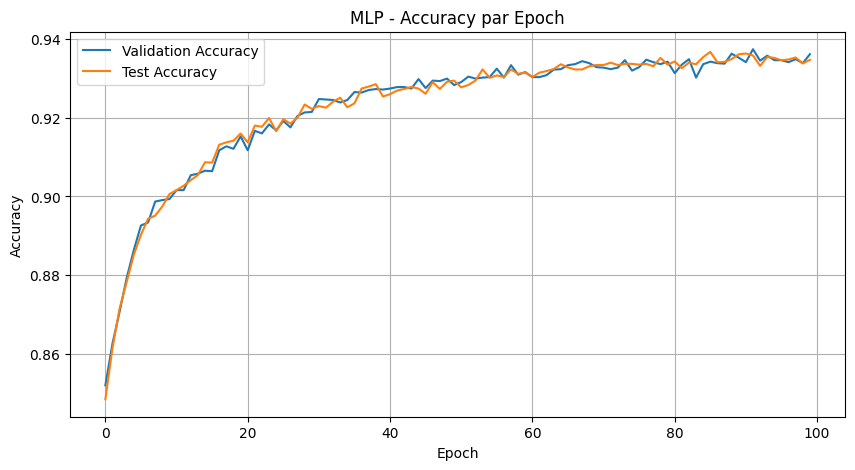

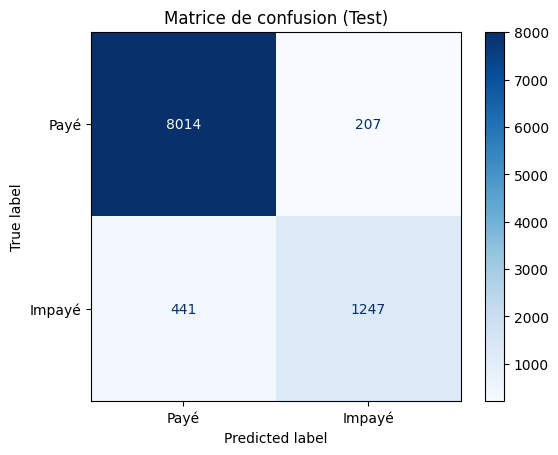

In [37]:
# 📈 Tracer les courbes
plt.figure(figsize=(10, 5))
plt.plot(val_scores, label="Validation Accuracy")
plt.plot(test_scores, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP - Accuracy par Epoch")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    y_true = data["test"]["y"].cpu().numpy()
    y_logits = apply_model(data["test"]).cpu().numpy()
    y_pred = (torch.sigmoid(torch.tensor(y_logits)) > 0.5).int().numpy()

# 📊 Affichage avec labels personnalisés
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, 
    display_labels=["Payé", "Impayé"],  # ordre : 0 = Payé, 1 = Impayé
    cmap="Blues"
)
plt.title("Matrice de confusion (Test)")
plt.show()

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ⏺️ Initialisation
val_scores = []
test_scores = []

n_epochs = 100
patience = 1000

batch_size = 512
epoch_size = math.ceil(len(train_idx) / batch_size)
timer = delu.tools.Timer()
early_stopping = delu.tools.EarlyStopping(patience, mode="max")
best = {
    "val": -math.inf,
    "test": -math.inf,
    "epoch": -1,
}

print(f"Device: {device.type.upper()}")
print("-" * 88 + "\n")
timer.run()

# 🔁 Entraînement
for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(data["train"], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(apply_model(batch), batch["y"])
        loss.backward()
        optimizer.step()

    val_score = evaluate("val")
    test_score = evaluate("test")
    val_scores.append(val_score)
    test_scores.append(test_score)

    print(f"(val) {val_score:.4f} (test) {test_score:.4f} [time] {timer}")

    early_stopping.update(val_score)
    if early_stopping.should_stop():
        break

    if val_score > best["val"]:
        print("🌸 New best epoch! 🌸")
        best = {"val": val_score, "test": test_score, "epoch": epoch}
    print()

print("\n\nResult:")
print(best)

Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 62/62 [00:00<00:00, 329.24it/s]


(val) 0.8795 (test) 0.8774 [time] 0:00:00.202679
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 62/62 [00:00<00:00, 345.00it/s]


(val) 0.8961 (test) 0.8955 [time] 0:00:00.394203
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 62/62 [00:00<00:00, 338.46it/s]


(val) 0.8986 (test) 0.8980 [time] 0:00:00.588706
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 62/62 [00:00<00:00, 351.22it/s]


(val) 0.8997 (test) 0.8997 [time] 0:00:00.776441
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 329.75it/s]


(val) 0.9058 (test) 0.9057 [time] 0:00:00.975513
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 62/62 [00:00<00:00, 340.13it/s]


(val) 0.9099 (test) 0.9088 [time] 0:00:01.169490
🌸 New best epoch! 🌸



Epoch 6: 100%|██████████| 62/62 [00:00<00:00, 343.21it/s]


(val) 0.9123 (test) 0.9125 [time] 0:00:01.361686
🌸 New best epoch! 🌸



Epoch 7: 100%|██████████| 62/62 [00:00<00:00, 343.27it/s]


(val) 0.9138 (test) 0.9123 [time] 0:00:01.554243
🌸 New best epoch! 🌸



Epoch 8: 100%|██████████| 62/62 [00:00<00:00, 355.86it/s]


(val) 0.9162 (test) 0.9164 [time] 0:00:01.739451
🌸 New best epoch! 🌸



Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 347.34it/s]


(val) 0.9150 (test) 0.9160 [time] 0:00:01.928937



Epoch 10: 100%|██████████| 62/62 [00:00<00:00, 345.51it/s]


(val) 0.9213 (test) 0.9189 [time] 0:00:02.119277
🌸 New best epoch! 🌸



Epoch 11: 100%|██████████| 62/62 [00:00<00:00, 349.60it/s]


(val) 0.9203 (test) 0.9203 [time] 0:00:02.308423



Epoch 12: 100%|██████████| 62/62 [00:00<00:00, 345.85it/s]


(val) 0.9223 (test) 0.9230 [time] 0:00:02.498844
🌸 New best epoch! 🌸



Epoch 13: 100%|██████████| 62/62 [00:00<00:00, 346.58it/s]


(val) 0.9215 (test) 0.9233 [time] 0:00:02.689519



Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 343.85it/s]


(val) 0.9230 (test) 0.9257 [time] 0:00:02.881886
🌸 New best epoch! 🌸



Epoch 15: 100%|██████████| 62/62 [00:00<00:00, 340.11it/s]


(val) 0.9251 (test) 0.9246 [time] 0:00:03.074893
🌸 New best epoch! 🌸



Epoch 16: 100%|██████████| 62/62 [00:00<00:00, 345.31it/s]


(val) 0.9233 (test) 0.9262 [time] 0:00:03.265509



Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 353.48it/s]


(val) 0.9246 (test) 0.9269 [time] 0:00:03.451578



Epoch 18: 100%|██████████| 62/62 [00:00<00:00, 354.08it/s]


(val) 0.9244 (test) 0.9247 [time] 0:00:03.637482



Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 346.85it/s]


(val) 0.9271 (test) 0.9269 [time] 0:00:03.827110
🌸 New best epoch! 🌸



Epoch 20: 100%|██████████| 62/62 [00:00<00:00, 353.44it/s]


(val) 0.9278 (test) 0.9265 [time] 0:00:04.013658
🌸 New best epoch! 🌸



Epoch 21: 100%|██████████| 62/62 [00:00<00:00, 356.07it/s]


(val) 0.9252 (test) 0.9281 [time] 0:00:04.199097



Epoch 22: 100%|██████████| 62/62 [00:00<00:00, 350.21it/s]


(val) 0.9272 (test) 0.9297 [time] 0:00:04.387466



Epoch 23: 100%|██████████| 62/62 [00:00<00:00, 355.40it/s]


(val) 0.9281 (test) 0.9282 [time] 0:00:04.572697
🌸 New best epoch! 🌸



Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 343.40it/s]


(val) 0.9290 (test) 0.9300 [time] 0:00:04.764689
🌸 New best epoch! 🌸



Epoch 25: 100%|██████████| 62/62 [00:00<00:00, 337.31it/s]


(val) 0.9307 (test) 0.9307 [time] 0:00:04.959409
🌸 New best epoch! 🌸



Epoch 26: 100%|██████████| 62/62 [00:00<00:00, 341.77it/s]


(val) 0.9329 (test) 0.9308 [time] 0:00:05.152035
🌸 New best epoch! 🌸



Epoch 27: 100%|██████████| 62/62 [00:00<00:00, 346.04it/s]


(val) 0.9320 (test) 0.9339 [time] 0:00:05.342063



Epoch 28: 100%|██████████| 62/62 [00:00<00:00, 345.72it/s]


(val) 0.9289 (test) 0.9311 [time] 0:00:05.532219



Epoch 29: 100%|██████████| 62/62 [00:00<00:00, 347.84it/s]


(val) 0.9323 (test) 0.9307 [time] 0:00:05.721474



Epoch 30: 100%|██████████| 62/62 [00:00<00:00, 345.05it/s]


(val) 0.9292 (test) 0.9335 [time] 0:00:05.912094



Epoch 31: 100%|██████████| 62/62 [00:00<00:00, 351.44it/s]


(val) 0.9286 (test) 0.9321 [time] 0:00:06.099381



Epoch 32: 100%|██████████| 62/62 [00:00<00:00, 355.44it/s]


(val) 0.9310 (test) 0.9312 [time] 0:00:06.284393



Epoch 33: 100%|██████████| 62/62 [00:00<00:00, 348.02it/s]


(val) 0.9319 (test) 0.9334 [time] 0:00:06.473682



Epoch 34: 100%|██████████| 62/62 [00:00<00:00, 346.50it/s]


(val) 0.9333 (test) 0.9344 [time] 0:00:06.664058
🌸 New best epoch! 🌸



Epoch 35: 100%|██████████| 62/62 [00:00<00:00, 347.69it/s]


(val) 0.9287 (test) 0.9320 [time] 0:00:06.853206



Epoch 36: 100%|██████████| 62/62 [00:00<00:00, 337.67it/s]


(val) 0.9318 (test) 0.9355 [time] 0:00:07.048118



Epoch 37: 100%|██████████| 62/62 [00:00<00:00, 327.75it/s]


(val) 0.9324 (test) 0.9330 [time] 0:00:07.252253



Epoch 38: 100%|██████████| 62/62 [00:00<00:00, 319.70it/s]


(val) 0.9344 (test) 0.9357 [time] 0:00:07.458713
🌸 New best epoch! 🌸



Epoch 39: 100%|██████████| 62/62 [00:00<00:00, 295.50it/s]


(val) 0.9328 (test) 0.9354 [time] 0:00:07.681500



Epoch 40: 100%|██████████| 62/62 [00:00<00:00, 313.29it/s]


(val) 0.9339 (test) 0.9354 [time] 0:00:07.891602



Epoch 41: 100%|██████████| 62/62 [00:00<00:00, 324.61it/s]


(val) 0.9345 (test) 0.9345 [time] 0:00:08.096627
🌸 New best epoch! 🌸



Epoch 42: 100%|██████████| 62/62 [00:00<00:00, 323.83it/s]


(val) 0.9348 (test) 0.9363 [time] 0:00:08.300925
🌸 New best epoch! 🌸



Epoch 43: 100%|██████████| 62/62 [00:00<00:00, 343.28it/s]


(val) 0.9321 (test) 0.9343 [time] 0:00:08.493397



Epoch 44: 100%|██████████| 62/62 [00:00<00:00, 336.59it/s]


(val) 0.9348 (test) 0.9378 [time] 0:00:08.688648



Epoch 45: 100%|██████████| 62/62 [00:00<00:00, 320.48it/s]


(val) 0.9369 (test) 0.9362 [time] 0:00:08.894189
🌸 New best epoch! 🌸



Epoch 46: 100%|██████████| 62/62 [00:00<00:00, 305.18it/s]


(val) 0.9334 (test) 0.9359 [time] 0:00:09.108858



Epoch 47: 100%|██████████| 62/62 [00:00<00:00, 347.37it/s]


(val) 0.9354 (test) 0.9372 [time] 0:00:09.298590



Epoch 48: 100%|██████████| 62/62 [00:00<00:00, 350.33it/s]


(val) 0.9334 (test) 0.9376 [time] 0:00:09.486604



Epoch 49: 100%|██████████| 62/62 [00:00<00:00, 347.38it/s]


(val) 0.9347 (test) 0.9366 [time] 0:00:09.676781



Epoch 50: 100%|██████████| 62/62 [00:00<00:00, 351.32it/s]


(val) 0.9353 (test) 0.9380 [time] 0:00:09.864526



Epoch 51: 100%|██████████| 62/62 [00:00<00:00, 351.35it/s]


(val) 0.9348 (test) 0.9375 [time] 0:00:10.052429



Epoch 52: 100%|██████████| 62/62 [00:00<00:00, 358.68it/s]


(val) 0.9360 (test) 0.9368 [time] 0:00:10.236186



Epoch 53: 100%|██████████| 62/62 [00:00<00:00, 349.58it/s]


(val) 0.9364 (test) 0.9365 [time] 0:00:10.425092



Epoch 54: 100%|██████████| 62/62 [00:00<00:00, 353.34it/s]


(val) 0.9383 (test) 0.9380 [time] 0:00:10.612218
🌸 New best epoch! 🌸



Epoch 55: 100%|██████████| 62/62 [00:00<00:00, 340.42it/s]


(val) 0.9369 (test) 0.9346 [time] 0:00:10.805706



Epoch 56: 100%|██████████| 62/62 [00:00<00:00, 344.22it/s]


(val) 0.9369 (test) 0.9370 [time] 0:00:10.997405



Epoch 57: 100%|██████████| 62/62 [00:00<00:00, 336.20it/s]


(val) 0.9384 (test) 0.9386 [time] 0:00:11.193207
🌸 New best epoch! 🌸



Epoch 58: 100%|██████████| 62/62 [00:00<00:00, 349.13it/s]


(val) 0.9367 (test) 0.9378 [time] 0:00:11.381714



Epoch 59: 100%|██████████| 62/62 [00:00<00:00, 330.79it/s]


(val) 0.9367 (test) 0.9355 [time] 0:00:11.580186



Epoch 60: 100%|██████████| 62/62 [00:00<00:00, 347.74it/s]


(val) 0.9387 (test) 0.9368 [time] 0:00:11.769264
🌸 New best epoch! 🌸



Epoch 61: 100%|██████████| 62/62 [00:00<00:00, 354.95it/s]


(val) 0.9373 (test) 0.9382 [time] 0:00:11.954960



Epoch 62: 100%|██████████| 62/62 [00:00<00:00, 341.62it/s]


(val) 0.9388 (test) 0.9372 [time] 0:00:12.147376
🌸 New best epoch! 🌸



Epoch 63: 100%|██████████| 62/62 [00:00<00:00, 330.65it/s]


(val) 0.9378 (test) 0.9385 [time] 0:00:12.346030



Epoch 64: 100%|██████████| 62/62 [00:00<00:00, 324.25it/s]


(val) 0.9369 (test) 0.9374 [time] 0:00:12.548264



Epoch 65: 100%|██████████| 62/62 [00:00<00:00, 338.59it/s]


(val) 0.9352 (test) 0.9388 [time] 0:00:12.742483



Epoch 66: 100%|██████████| 62/62 [00:00<00:00, 347.89it/s]


(val) 0.9389 (test) 0.9387 [time] 0:00:12.932040
🌸 New best epoch! 🌸



Epoch 67: 100%|██████████| 62/62 [00:00<00:00, 339.24it/s]


(val) 0.9383 (test) 0.9364 [time] 0:00:13.125626



Epoch 68: 100%|██████████| 62/62 [00:00<00:00, 331.32it/s]


(val) 0.9358 (test) 0.9372 [time] 0:00:13.323929



Epoch 69: 100%|██████████| 62/62 [00:00<00:00, 343.88it/s]


(val) 0.9386 (test) 0.9393 [time] 0:00:13.514986



Epoch 70: 100%|██████████| 62/62 [00:00<00:00, 349.78it/s]


(val) 0.9372 (test) 0.9368 [time] 0:00:13.703213



Epoch 71: 100%|██████████| 62/62 [00:00<00:00, 347.35it/s]


(val) 0.9377 (test) 0.9371 [time] 0:00:13.892384



Epoch 72: 100%|██████████| 62/62 [00:00<00:00, 342.93it/s]


(val) 0.9389 (test) 0.9394 [time] 0:00:14.085253



Epoch 73: 100%|██████████| 62/62 [00:00<00:00, 352.19it/s]


(val) 0.9391 (test) 0.9382 [time] 0:00:14.272625
🌸 New best epoch! 🌸



Epoch 74: 100%|██████████| 62/62 [00:00<00:00, 349.46it/s]


(val) 0.9373 (test) 0.9386 [time] 0:00:14.461415



Epoch 75: 100%|██████████| 62/62 [00:00<00:00, 322.67it/s]


(val) 0.9401 (test) 0.9377 [time] 0:00:14.665732
🌸 New best epoch! 🌸



Epoch 76: 100%|██████████| 62/62 [00:00<00:00, 339.80it/s]


(val) 0.9369 (test) 0.9390 [time] 0:00:14.858899



Epoch 77: 100%|██████████| 62/62 [00:00<00:00, 333.21it/s]


(val) 0.9391 (test) 0.9400 [time] 0:00:15.056427



Epoch 78: 100%|██████████| 62/62 [00:00<00:00, 353.11it/s]


(val) 0.9391 (test) 0.9391 [time] 0:00:15.243228



Epoch 79: 100%|██████████| 62/62 [00:00<00:00, 346.33it/s]


(val) 0.9408 (test) 0.9371 [time] 0:00:15.433313
🌸 New best epoch! 🌸



Epoch 80: 100%|██████████| 62/62 [00:00<00:00, 352.92it/s]


(val) 0.9384 (test) 0.9386 [time] 0:00:15.619952



Epoch 81: 100%|██████████| 62/62 [00:00<00:00, 357.07it/s]


(val) 0.9401 (test) 0.9393 [time] 0:00:15.804891



Epoch 82: 100%|██████████| 62/62 [00:00<00:00, 353.99it/s]


(val) 0.9405 (test) 0.9401 [time] 0:00:15.991808



Epoch 83: 100%|██████████| 62/62 [00:00<00:00, 346.95it/s]


(val) 0.9417 (test) 0.9402 [time] 0:00:16.182014
🌸 New best epoch! 🌸



Epoch 84: 100%|██████████| 62/62 [00:00<00:00, 347.61it/s]


(val) 0.9403 (test) 0.9379 [time] 0:00:16.372523



Epoch 85: 100%|██████████| 62/62 [00:00<00:00, 326.70it/s]


(val) 0.9437 (test) 0.9392 [time] 0:00:16.573796
🌸 New best epoch! 🌸



Epoch 86: 100%|██████████| 62/62 [00:00<00:00, 346.85it/s]


(val) 0.9411 (test) 0.9400 [time] 0:00:16.763965



Epoch 87: 100%|██████████| 62/62 [00:00<00:00, 338.67it/s]


(val) 0.9434 (test) 0.9414 [time] 0:00:16.958302



Epoch 88: 100%|██████████| 62/62 [00:00<00:00, 339.70it/s]


(val) 0.9411 (test) 0.9393 [time] 0:00:17.152041



Epoch 89: 100%|██████████| 62/62 [00:00<00:00, 340.66it/s]


(val) 0.9401 (test) 0.9376 [time] 0:00:17.345209



Epoch 90: 100%|██████████| 62/62 [00:00<00:00, 340.39it/s]


(val) 0.9418 (test) 0.9402 [time] 0:00:17.538508



Epoch 91: 100%|██████████| 62/62 [00:00<00:00, 347.16it/s]


(val) 0.9437 (test) 0.9417 [time] 0:00:17.728104



Epoch 92: 100%|██████████| 62/62 [00:00<00:00, 351.18it/s]


(val) 0.9408 (test) 0.9381 [time] 0:00:17.915595



Epoch 93: 100%|██████████| 62/62 [00:00<00:00, 342.81it/s]


(val) 0.9425 (test) 0.9405 [time] 0:00:18.108321



Epoch 94: 100%|██████████| 62/62 [00:00<00:00, 338.01it/s]


(val) 0.9429 (test) 0.9397 [time] 0:00:18.302797



Epoch 95: 100%|██████████| 62/62 [00:00<00:00, 352.62it/s]


(val) 0.9434 (test) 0.9405 [time] 0:00:18.489221



Epoch 96: 100%|██████████| 62/62 [00:00<00:00, 340.80it/s]


(val) 0.9422 (test) 0.9390 [time] 0:00:18.682828



Epoch 97: 100%|██████████| 62/62 [00:00<00:00, 335.05it/s]


(val) 0.9406 (test) 0.9394 [time] 0:00:18.879392



Epoch 98: 100%|██████████| 62/62 [00:00<00:00, 306.71it/s]


(val) 0.9423 (test) 0.9401 [time] 0:00:19.092339



Epoch 99: 100%|██████████| 62/62 [00:00<00:00, 344.68it/s]

(val) 0.9431 (test) 0.9418 [time] 0:00:19.283278



Result:
{'val': 0.9437365964425382, 'test': 0.9392471490564134, 'epoch': 85}


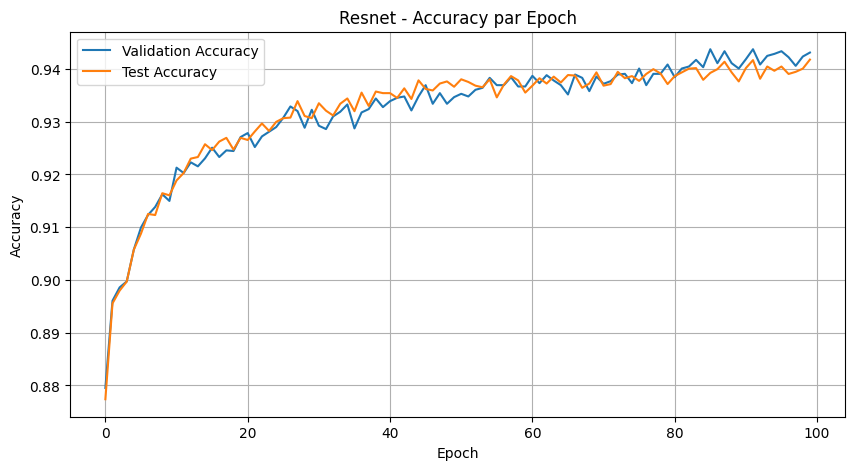

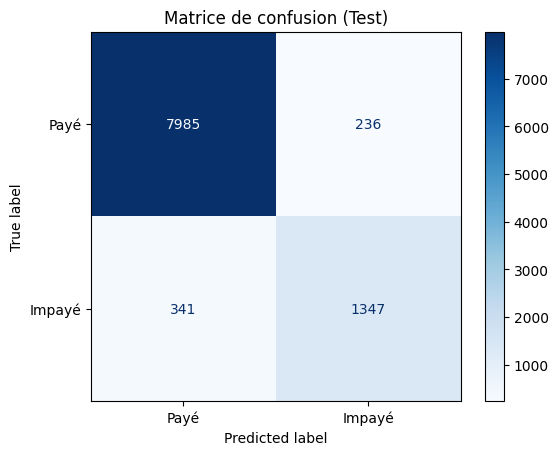

In [24]:
# 📈 Tracer les courbes
plt.figure(figsize=(10, 5))
plt.plot(val_scores, label="Validation Accuracy")
plt.plot(test_scores, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Resnet - Accuracy par Epoch")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    y_true = data["test"]["y"].cpu().numpy()
    y_logits = apply_model(data["test"]).cpu().numpy()
    y_pred = (torch.sigmoid(torch.tensor(y_logits)) > 0.5).int().numpy()

# 📊 Affichage avec labels personnalisés
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, 
    display_labels=["Payé", "Impayé"],  # ordre : 0 = Payé, 1 = Impayé
    cmap="Blues"
)
plt.title("Matrice de confusion (Test)")
plt.show()

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ⏺️ Initialisation
val_scores = []
test_scores = []

n_epochs = 100
patience = 1000

batch_size = 512
epoch_size = math.ceil(len(train_idx) / batch_size)
timer = delu.tools.Timer()
early_stopping = delu.tools.EarlyStopping(patience, mode="max")
best = {
    "val": -math.inf,
    "test": -math.inf,
    "epoch": -1,
}

print(f"Device: {device.type.upper()}")
print("-" * 88 + "\n")
timer.run()

# 🔁 Entraînement
for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(data["train"], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(apply_model(batch), batch["y"])
        loss.backward()
        optimizer.step()

    val_score = evaluate("val")
    test_score = evaluate("test")
    val_scores.append(val_score)
    test_scores.append(test_score)

    print(f"(val) {val_score:.4f} (test) {test_score:.4f} [time] {timer}")

    early_stopping.update(val_score)
    if early_stopping.should_stop():
        break

    if val_score > best["val"]:
        print("🌸 New best epoch! 🌸")
        best = {"val": val_score, "test": test_score, "epoch": epoch}
    print()

print("\n\nResult:")
print(best)

Device: CUDA
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 62/62 [00:03<00:00, 20.61it/s]


(val) 0.8615 (test) 0.8583 [time] 0:00:03.779823
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 62/62 [00:02<00:00, 20.71it/s]


(val) 0.8788 (test) 0.8782 [time] 0:00:07.569654
🌸 New best epoch! 🌸



Epoch 2: 100%|██████████| 62/62 [00:03<00:00, 20.55it/s]


(val) 0.8913 (test) 0.8907 [time] 0:00:11.392893
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 62/62 [00:03<00:00, 20.39it/s]


(val) 0.8984 (test) 0.8993 [time] 0:00:15.242451
🌸 New best epoch! 🌸



Epoch 4: 100%|██████████| 62/62 [00:03<00:00, 20.27it/s]


(val) 0.9003 (test) 0.9020 [time] 0:00:19.120177
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 62/62 [00:03<00:00, 20.13it/s]


(val) 0.9043 (test) 0.9082 [time] 0:00:23.032639
🌸 New best epoch! 🌸



Epoch 6: 100%|██████████| 62/62 [00:03<00:00, 19.84it/s]


(val) 0.9084 (test) 0.9081 [time] 0:00:27.003721
🌸 New best epoch! 🌸



Epoch 7: 100%|██████████| 62/62 [00:03<00:00, 19.62it/s]


(val) 0.9152 (test) 0.9168 [time] 0:00:31.022712
🌸 New best epoch! 🌸



Epoch 8: 100%|██████████| 62/62 [00:03<00:00, 19.37it/s]


(val) 0.9193 (test) 0.9200 [time] 0:00:35.088448
🌸 New best epoch! 🌸



Epoch 9: 100%|██████████| 62/62 [00:03<00:00, 19.12it/s]


(val) 0.9246 (test) 0.9203 [time] 0:00:39.208301
🌸 New best epoch! 🌸



Epoch 10: 100%|██████████| 62/62 [00:03<00:00, 19.19it/s]


(val) 0.9243 (test) 0.9242 [time] 0:00:43.307864



Epoch 11: 100%|██████████| 62/62 [00:03<00:00, 19.48it/s]


(val) 0.9267 (test) 0.9213 [time] 0:00:47.341894
🌸 New best epoch! 🌸



Epoch 12: 100%|██████████| 62/62 [00:03<00:00, 19.76it/s]


(val) 0.9282 (test) 0.9274 [time] 0:00:51.315233
🌸 New best epoch! 🌸



Epoch 13: 100%|██████████| 62/62 [00:03<00:00, 20.00it/s]


(val) 0.9278 (test) 0.9269 [time] 0:00:55.241828



Epoch 14: 100%|██████████| 62/62 [00:03<00:00, 20.17it/s]


(val) 0.9305 (test) 0.9296 [time] 0:00:59.124268
🌸 New best epoch! 🌸



Epoch 15: 100%|██████████| 62/62 [00:03<00:00, 20.26it/s]


(val) 0.9325 (test) 0.9336 [time] 0:01:03.000791
🌸 New best epoch! 🌸



Epoch 16: 100%|██████████| 62/62 [00:03<00:00, 20.31it/s]


(val) 0.9363 (test) 0.9355 [time] 0:01:06.862659
🌸 New best epoch! 🌸



Epoch 17: 100%|██████████| 62/62 [00:03<00:00, 20.37it/s]


(val) 0.9325 (test) 0.9345 [time] 0:01:10.717562



Epoch 18: 100%|██████████| 62/62 [00:03<00:00, 20.42it/s]


(val) 0.9383 (test) 0.9377 [time] 0:01:14.556491
🌸 New best epoch! 🌸



Epoch 19: 100%|██████████| 62/62 [00:03<00:00, 20.44it/s]


(val) 0.9348 (test) 0.9365 [time] 0:01:18.393352



Epoch 20: 100%|██████████| 62/62 [00:03<00:00, 20.45it/s]


(val) 0.9345 (test) 0.9373 [time] 0:01:22.226785



Epoch 21: 100%|██████████| 62/62 [00:03<00:00, 20.41it/s]


(val) 0.9349 (test) 0.9361 [time] 0:01:26.063000



Epoch 22: 100%|██████████| 62/62 [00:03<00:00, 20.38it/s]


(val) 0.9401 (test) 0.9418 [time] 0:01:29.917213
🌸 New best epoch! 🌸



Epoch 23: 100%|██████████| 62/62 [00:03<00:00, 20.38it/s]


(val) 0.9373 (test) 0.9387 [time] 0:01:33.773683



Epoch 24: 100%|██████████| 62/62 [00:03<00:00, 20.33it/s]


(val) 0.9408 (test) 0.9420 [time] 0:01:37.632717
🌸 New best epoch! 🌸



Epoch 25: 100%|██████████| 62/62 [00:03<00:00, 20.24it/s]


(val) 0.9416 (test) 0.9407 [time] 0:01:41.512078
🌸 New best epoch! 🌸



Epoch 26: 100%|██████████| 62/62 [00:03<00:00, 20.20it/s]


(val) 0.9326 (test) 0.9366 [time] 0:01:45.402199



Epoch 27: 100%|██████████| 62/62 [00:03<00:00, 20.15it/s]


(val) 0.9411 (test) 0.9463 [time] 0:01:49.307339



Epoch 28: 100%|██████████| 62/62 [00:03<00:00, 20.09it/s]


(val) 0.9453 (test) 0.9446 [time] 0:01:53.222639
🌸 New best epoch! 🌸



Epoch 29: 100%|██████████| 62/62 [00:03<00:00, 20.00it/s]


(val) 0.9416 (test) 0.9441 [time] 0:01:57.153331



Epoch 30: 100%|██████████| 62/62 [00:03<00:00, 20.05it/s]


(val) 0.9455 (test) 0.9468 [time] 0:02:01.075178
🌸 New best epoch! 🌸



Epoch 31: 100%|██████████| 62/62 [00:03<00:00, 20.03it/s]


(val) 0.9461 (test) 0.9476 [time] 0:02:05.000204
🌸 New best epoch! 🌸



Epoch 32: 100%|██████████| 62/62 [00:03<00:00, 20.04it/s]


(val) 0.9460 (test) 0.9507 [time] 0:02:08.924730



Epoch 33: 100%|██████████| 62/62 [00:03<00:00, 20.07it/s]


(val) 0.9464 (test) 0.9499 [time] 0:02:12.841510
🌸 New best epoch! 🌸



Epoch 34: 100%|██████████| 62/62 [00:03<00:00, 20.11it/s]


(val) 0.9436 (test) 0.9475 [time] 0:02:16.741007



Epoch 35: 100%|██████████| 62/62 [00:03<00:00, 20.15it/s]


(val) 0.9485 (test) 0.9487 [time] 0:02:20.642334
🌸 New best epoch! 🌸



Epoch 36: 100%|██████████| 62/62 [00:03<00:00, 20.16it/s]


(val) 0.9442 (test) 0.9491 [time] 0:02:24.539888



Epoch 37: 100%|██████████| 62/62 [00:03<00:00, 20.21it/s]


(val) 0.9488 (test) 0.9499 [time] 0:02:28.424555
🌸 New best epoch! 🌸



Epoch 38: 100%|██████████| 62/62 [00:03<00:00, 20.23it/s]


(val) 0.9465 (test) 0.9501 [time] 0:02:32.307953



Epoch 39: 100%|██████████| 62/62 [00:03<00:00, 20.25it/s]


(val) 0.9478 (test) 0.9509 [time] 0:02:36.184232



Epoch 40: 100%|██████████| 62/62 [00:03<00:00, 20.23it/s]


(val) 0.9482 (test) 0.9508 [time] 0:02:40.058661



Epoch 41: 100%|██████████| 62/62 [00:03<00:00, 20.25it/s]


(val) 0.9497 (test) 0.9547 [time] 0:02:43.936162
🌸 New best epoch! 🌸



Epoch 42: 100%|██████████| 62/62 [00:03<00:00, 20.26it/s]


(val) 0.9466 (test) 0.9474 [time] 0:02:47.811795



Epoch 43: 100%|██████████| 62/62 [00:03<00:00, 20.28it/s]


(val) 0.9523 (test) 0.9542 [time] 0:02:51.687109
🌸 New best epoch! 🌸



Epoch 44: 100%|██████████| 62/62 [00:03<00:00, 20.28it/s]


(val) 0.9503 (test) 0.9547 [time] 0:02:55.564814



Epoch 45: 100%|██████████| 62/62 [00:03<00:00, 20.23it/s]


(val) 0.9502 (test) 0.9567 [time] 0:02:59.443390



Epoch 46: 100%|██████████| 62/62 [00:03<00:00, 20.21it/s]


(val) 0.9488 (test) 0.9521 [time] 0:03:03.321665



Epoch 47: 100%|██████████| 62/62 [00:03<00:00, 20.24it/s]


(val) 0.9531 (test) 0.9558 [time] 0:03:07.196377
🌸 New best epoch! 🌸



Epoch 48: 100%|██████████| 62/62 [00:03<00:00, 20.21it/s]


(val) 0.9518 (test) 0.9537 [time] 0:03:11.076554



Epoch 49: 100%|██████████| 62/62 [00:03<00:00, 20.25it/s]


(val) 0.9511 (test) 0.9547 [time] 0:03:14.954366



Epoch 50: 100%|██████████| 62/62 [00:03<00:00, 20.21it/s]


(val) 0.9532 (test) 0.9569 [time] 0:03:18.835401
🌸 New best epoch! 🌸



Epoch 51: 100%|██████████| 62/62 [00:03<00:00, 20.20it/s]


(val) 0.9542 (test) 0.9561 [time] 0:03:22.717717
🌸 New best epoch! 🌸



Epoch 52: 100%|██████████| 62/62 [00:03<00:00, 20.20it/s]


(val) 0.9540 (test) 0.9542 [time] 0:03:26.607401



Epoch 53: 100%|██████████| 62/62 [00:03<00:00, 20.19it/s]


(val) 0.9532 (test) 0.9584 [time] 0:03:30.494854



Epoch 54: 100%|██████████| 62/62 [00:03<00:00, 20.22it/s]


(val) 0.9542 (test) 0.9599 [time] 0:03:34.377489



Epoch 55: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9537 (test) 0.9577 [time] 0:03:38.265656



Epoch 56: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9540 (test) 0.9575 [time] 0:03:42.160410



Epoch 57: 100%|██████████| 62/62 [00:03<00:00, 20.15it/s]


(val) 0.9556 (test) 0.9568 [time] 0:03:46.061728
🌸 New best epoch! 🌸



Epoch 58: 100%|██████████| 62/62 [00:03<00:00, 20.19it/s]


(val) 0.9565 (test) 0.9568 [time] 0:03:49.953719
🌸 New best epoch! 🌸



Epoch 59: 100%|██████████| 62/62 [00:03<00:00, 20.19it/s]


(val) 0.9567 (test) 0.9548 [time] 0:03:53.838511
🌸 New best epoch! 🌸



Epoch 60: 100%|██████████| 62/62 [00:03<00:00, 20.19it/s]


(val) 0.9541 (test) 0.9556 [time] 0:03:57.728781



Epoch 61: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9518 (test) 0.9576 [time] 0:04:01.624487



Epoch 62: 100%|██████████| 62/62 [00:03<00:00, 20.17it/s]


(val) 0.9546 (test) 0.9594 [time] 0:04:05.520083



Epoch 63: 100%|██████████| 62/62 [00:03<00:00, 20.16it/s]


(val) 0.9570 (test) 0.9580 [time] 0:04:09.416616
🌸 New best epoch! 🌸



Epoch 64: 100%|██████████| 62/62 [00:03<00:00, 20.22it/s]


(val) 0.9570 (test) 0.9583 [time] 0:04:13.304932



Epoch 65: 100%|██████████| 62/62 [00:03<00:00, 20.14it/s]


(val) 0.9553 (test) 0.9573 [time] 0:04:17.207516



Epoch 66: 100%|██████████| 62/62 [00:03<00:00, 20.15it/s]


(val) 0.9562 (test) 0.9600 [time] 0:04:21.105862



Epoch 67: 100%|██████████| 62/62 [00:03<00:00, 20.14it/s]


(val) 0.9557 (test) 0.9582 [time] 0:04:25.006525



Epoch 68: 100%|██████████| 62/62 [00:03<00:00, 20.16it/s]


(val) 0.9545 (test) 0.9552 [time] 0:04:28.900976



Epoch 69: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9542 (test) 0.9576 [time] 0:04:32.791475



Epoch 70: 100%|██████████| 62/62 [00:03<00:00, 20.14it/s]


(val) 0.9576 (test) 0.9604 [time] 0:04:36.691319
🌸 New best epoch! 🌸



Epoch 71: 100%|██████████| 62/62 [00:03<00:00, 20.16it/s]


(val) 0.9550 (test) 0.9591 [time] 0:04:40.589055



Epoch 72: 100%|██████████| 62/62 [00:03<00:00, 20.17it/s]


(val) 0.9591 (test) 0.9605 [time] 0:04:44.482051
🌸 New best epoch! 🌸



Epoch 73: 100%|██████████| 62/62 [00:03<00:00, 20.17it/s]


(val) 0.9569 (test) 0.9603 [time] 0:04:48.377895



Epoch 74: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9566 (test) 0.9597 [time] 0:04:52.272887



Epoch 75: 100%|██████████| 62/62 [00:03<00:00, 20.17it/s]


(val) 0.9555 (test) 0.9592 [time] 0:04:56.169754



Epoch 76: 100%|██████████| 62/62 [00:03<00:00, 20.16it/s]


(val) 0.9591 (test) 0.9616 [time] 0:05:00.065859



Epoch 77: 100%|██████████| 62/62 [00:03<00:00, 20.17it/s]


(val) 0.9576 (test) 0.9588 [time] 0:05:03.960808



Epoch 78: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9584 (test) 0.9597 [time] 0:05:07.854854



Epoch 79: 100%|██████████| 62/62 [00:03<00:00, 20.19it/s]


(val) 0.9579 (test) 0.9620 [time] 0:05:11.746199



Epoch 80: 100%|██████████| 62/62 [00:03<00:00, 20.14it/s]


(val) 0.9595 (test) 0.9609 [time] 0:05:15.647446
🌸 New best epoch! 🌸



Epoch 81: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9595 (test) 0.9616 [time] 0:05:19.543662



Epoch 82: 100%|██████████| 62/62 [00:03<00:00, 20.20it/s]


(val) 0.9596 (test) 0.9620 [time] 0:05:23.426451
🌸 New best epoch! 🌸



Epoch 83: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9590 (test) 0.9598 [time] 0:05:27.316584



Epoch 84: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9586 (test) 0.9601 [time] 0:05:31.202246



Epoch 85: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9579 (test) 0.9589 [time] 0:05:35.095287



Epoch 86: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9572 (test) 0.9616 [time] 0:05:38.991291



Epoch 87: 100%|██████████| 62/62 [00:03<00:00, 20.20it/s]


(val) 0.9603 (test) 0.9610 [time] 0:05:42.876703
🌸 New best epoch! 🌸



Epoch 88: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9614 (test) 0.9637 [time] 0:05:46.771228
🌸 New best epoch! 🌸



Epoch 89: 100%|██████████| 62/62 [00:03<00:00, 20.21it/s]


(val) 0.9604 (test) 0.9626 [time] 0:05:50.656489



Epoch 90: 100%|██████████| 62/62 [00:03<00:00, 20.15it/s]


(val) 0.9595 (test) 0.9607 [time] 0:05:54.550572



Epoch 91: 100%|██████████| 62/62 [00:03<00:00, 20.20it/s]


(val) 0.9608 (test) 0.9632 [time] 0:05:58.440297



Epoch 92: 100%|██████████| 62/62 [00:03<00:00, 20.20it/s]


(val) 0.9598 (test) 0.9610 [time] 0:06:02.330713



Epoch 93: 100%|██████████| 62/62 [00:03<00:00, 20.19it/s]


(val) 0.9606 (test) 0.9610 [time] 0:06:06.213246



Epoch 94: 100%|██████████| 62/62 [00:03<00:00, 20.17it/s]


(val) 0.9589 (test) 0.9616 [time] 0:06:10.108116



Epoch 95: 100%|██████████| 62/62 [00:03<00:00, 20.20it/s]


(val) 0.9600 (test) 0.9625 [time] 0:06:13.998978



Epoch 96: 100%|██████████| 62/62 [00:03<00:00, 20.21it/s]


(val) 0.9593 (test) 0.9611 [time] 0:06:17.882492



Epoch 97: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9577 (test) 0.9605 [time] 0:06:21.774240



Epoch 98: 100%|██████████| 62/62 [00:03<00:00, 20.19it/s]


(val) 0.9595 (test) 0.9623 [time] 0:06:25.668010



Epoch 99: 100%|██████████| 62/62 [00:03<00:00, 20.18it/s]


(val) 0.9604 (test) 0.9630 [time] 0:06:29.563211



Result:
{'val': 0.9613977545099028, 'test': 0.963669391462307, 'epoch': 88}


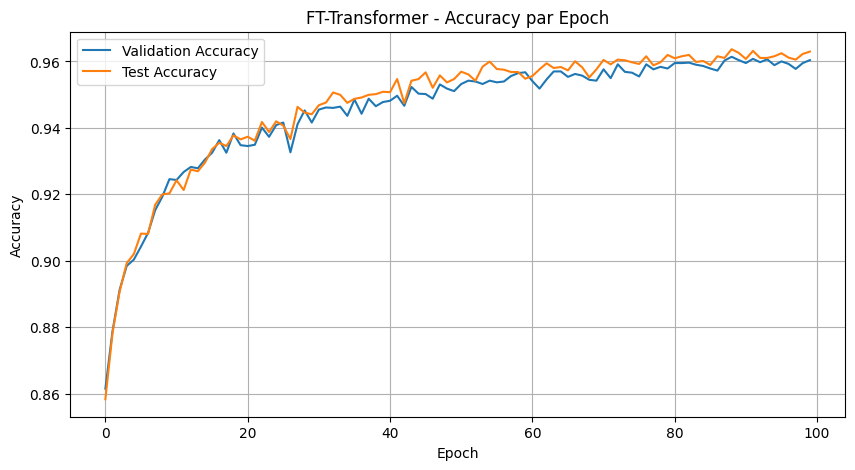

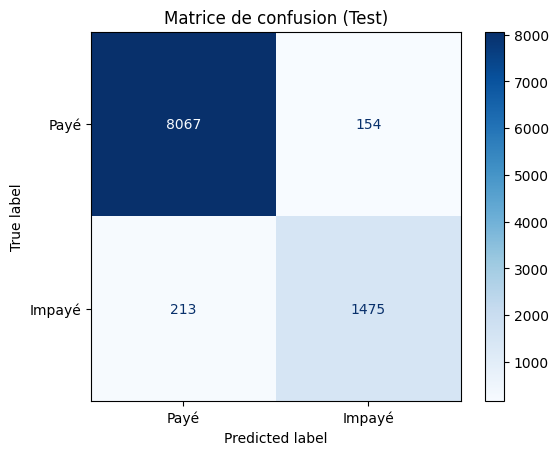

In [31]:
# 📈 Tracer les courbes
plt.figure(figsize=(10, 5))
plt.plot(val_scores, label="Validation Accuracy")
plt.plot(test_scores, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("FT-Transformer - Accuracy par Epoch")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    y_true = data["test"]["y"].cpu().numpy()
    y_logits = apply_model(data["test"]).cpu().numpy()
    y_pred = (torch.sigmoid(torch.tensor(y_logits)) > 0.5).int().numpy()

# 📊 Affichage avec labels personnalisés
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, 
    display_labels=["Payé", "Impayé"],  # ordre : 0 = Payé, 1 = Impayé
    cmap="Blues"
)
plt.title("Matrice de confusion (Test)")
plt.show()